## ARCH Model Forecasting

**Functions**

`sm.OLS`, `sm.WLS`


### Exercise 54

Use 50% of the sample to estimate your preferred GARCH model for returns to the S&P 500 and the
EUR/USD rate, and construct forecasts for the remaining period.

In [1]:
# Setup
%matplotlib inline

In [2]:
from arch import arch_model
import pandas as pd
import seaborn as sns
from pandas.plotting import register_matplotlib_converters
import matplotlib.pyplot as plt
import numpy as np
register_matplotlib_converters()

sns.set_style("darkgrid")
plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=14)

#### Discussion

These are standard imports and commands to configure matplotlib.  The command
is needed when plotting pandas Series and DataFrames that have 
date indices.

In [3]:
sp500 = pd.read_hdf('./data/arch-data.h5','sp500')
# Get the series
sp500 = sp500.SP500
returns = 1000 * sp500.pct_change().dropna()
# TARCH(1,1,1)
mod = arch_model(returns, o=1, power=1.0)
last = returns.index[returns.shape[0] // 2]
res = mod.fit(last_obs=last, disp="off")
in_samp_variance = res.conditional_volatility ** 2
# Look at the last 5 observations that have volatilities
print(last)
in_samp_variance.dropna().tail()

2015-01-07 00:00:00


DATE
2014-12-30     44.273915
2014-12-31     54.255578
2015-01-02     83.900729
2015-01-05     73.360890
2015-01-06    142.303293
Name: cond_vol, dtype: float64

In [4]:
forecasts = res.forecast(align="target")
oos_variance = forecasts.variance.dropna()
oos_variance

,h.1
DATE,
2015-01-07,164.597069
2015-01-08,135.068841
2015-01-09,111.715522
2015-01-12,133.144961
2015-01-13,151.692925
...,...
2019-12-24,20.407729
2019-12-26,20.146122
2019-12-27,18.951015


#### Discussion

This cell starts by importing the data and creating returns using a scale of
1000. The TARCH(1,1,1) model is constructed using `arch_model` and
then estimated by setting `last_obs` which sets the final observation
used in the fit. Note that `last_obs` is not actually used in fitting,
and only dates < `last_obs` are.

The forecasts are computed using `forecast` with `align` set to
"target". This simplifies evaluating forecasts since the forecast
is already aligned with the evaluation sample. 

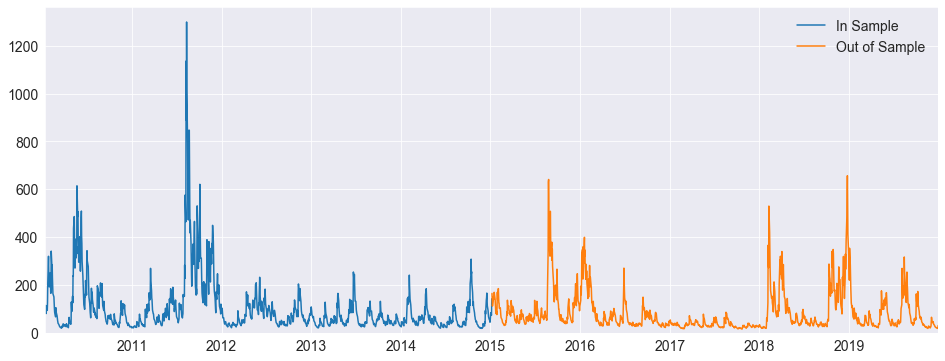

In [5]:
fig, ax = plt.subplots(1, 1)
plt.plot(in_samp_variance, label="In Sample")
plt.plot(oos_variance, label="Out of Sample")
ax.set_xlim(in_samp_variance.index[0], oos_variance.index[-1])
ylim = ax.set_ylim(0, ax.get_ylim()[1])
# The _ is used to capture the output from the legend command so that
# does not print
_ = plt.legend(frameon=False)

#### Discussion

Here we plot the fitted and foreast variance.
 

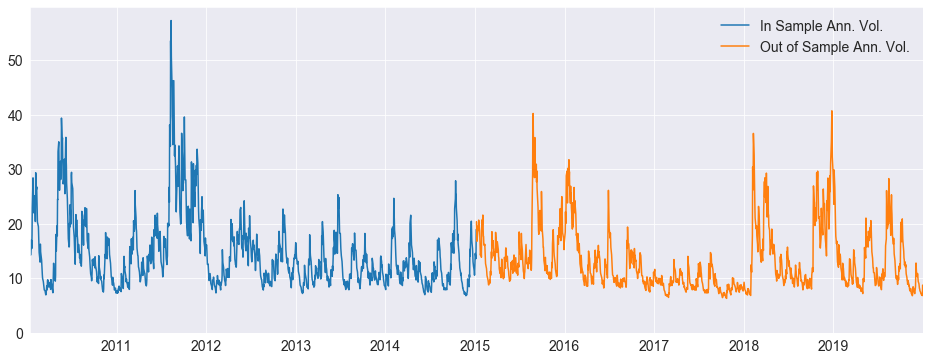

In [6]:
_, ax = plt.subplots(1, 1)
plt.plot(np.sqrt(252*in_samp_variance / 100), label="In Sample Ann. Vol.")
plt.plot(np.sqrt(252*oos_variance / 100), label="Out of Sample Ann. Vol.")
ax.set_xlim(in_samp_variance.index[0], oos_variance.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
_ = plt.legend(frameon=False)

#### Discussion

We can also plot the volaitlity.  Note that the variance is divided by 100 so that
it is the annualized percentage vol. This is identical what would  happen if returns
had been initially scaled by 100 rather than 1000. 

### Exercise 55

Evaluate the accuracy of the forecasts.

In [7]:
# Join the returns and the variance forecasts
combined = pd.concat([returns, oos_variance], axis = 1)
combined.columns = ["returns","oos_variance"]
# Remove mossing
combined = combined.dropna() 

#### Discussion

We start by by joining the forecast variance with the returns. 
Dropping missing is a simple method to remove observations without
a forecast. 

In [10]:
import statsmodels.api as sm

# Construct the error
mu = res.params["mu"]
variance_error = (combined.returns - mu) ** 2 - combined.oos_variance
x = sm.add_constant(combined.oos_variance)

res = sm.OLS(variance_error, x).fit(cov_type="HC0")
res.summary()

C:\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                   0.03104
Date:                Sat, 25 Jan 2020   Prob (F-statistic):              0.860
Time:                        00:28:29   Log-Likelihood:                -8095.5
No. Observations:                1255   AIC:                         1.619e+04
Df Residuals:                    1253   BIC:                         1.621e+04
Df Model:                           1                                         
Covariance Type:                  HC0                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -7.2936     11.385     -0.641      0.522     -29.608      15.020
oos_variance    -0.0296      0.168     -0.176      0.860      -0.359       0.300
==============================================================================
Omnibus:                     1316.028   Durbin-Watson:                   2.005
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            93722.017
Skew:                           5.001   Prob(JB):                         0.00
Kurtosis:                      44.137   Cond. No.                         162.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity robust (HC0)
"""

#### Discussion

We use a Mincer-Zarnowitz regression of the forecast error, which is defined

$$ \left(r_{t+1}-\hat{\mu}\right)^2 - \hat{\sigma}^2_{t+1},$$

on a constant and the forecast variance. We set `cov_type` to "HC0" to get
White's covariance estimator.  

In [ ]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")


#### Discussion

A Wald test of the null $H_0:\alpha=\beta=0$ is used to jointly
test the parameters.

In [12]:
res = sm.WLS(variance_error, x, weights=1./(combined.oos_variance**2)).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            WLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.2804
Date:                Sat, 25 Jan 2020   Prob (F-statistic):              0.597
Time:                        00:33:44   Log-Likelihood:                -7637.6
No. Observations:                1255   AIC:                         1.528e+04
Df Residuals:                    1253   BIC:                         1.529e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -5.1783      3.976     -1.303      0.193     -12.978       2.621
oos_variance    -0.0526      0.099     -0.530      0.597      -0.248       0.142
==============================================================================
Omnibus:                     1831.139   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           638127.119
Skew:                           8.357   Prob(JB):                         0.00
Kurtosis:                     112.196   Cond. No.                         77.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We can also use a weighted LS estimator where the variance is the inverse
of the squared forecast.  The creates the MZ-GLS test.


In [ ]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")

#### Discussion

The Wald test is the same only using the WLS result.


### Exercise 56

Evaluate the accuracy of forecasts from a 2-year backward moving average variance.

In [ ]:
rolling_variance = (returns**2).rolling(2*252).mean()
rolling_variance = rolling_variance.shift(1)
rolling_variance.name = "rolling_variance"
rolling_mean = returns.rolling(2*252).mean()
rolling_mean = rolling_mean.shift(1)
rolling_mean.name = "rolling_mean"
combined = pd.concat([combined, rolling_mean, rolling_variance], axis=1).dropna()

_, ax = plt.subplots(1, 1)
plt.plot(combined.oos_variance, label="TARCH")
plt.plot(combined.rolling_variance, label="Rolling")
ax.set_xlim(combined.index[0], combined.index[-1])
ax.set_ylim(0, ax.get_ylim()[1])
_ = plt.legend(frameon=False)

#### Discussion


In [ ]:
# Construct the error
eps = combined.returns - combined.rolling_mean
variance_error = eps ** 2 - combined.rolling_variance
x = sm.add_constant(combined.rolling_variance)

res = sm.OLS(variance_error, x).fit(cov_type="HC0")
res.summary()

#### Discussion

In [ ]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")

#### Discussion

In [ ]:
res = sm.WLS(variance_error, x, weights=1./(combined.rolling_variance**2)).fit()
res.summary()

#### Discussion


In [ ]:
test = res.wald_test(np.eye(2), use_f=False)
print(f"Stat: {test.statistic[0,0]}, Pval:{test.pvalue}")

#### Discussion


### Exercise 57

Compare the ARCH-model forecasts to a naive 2-year backward looking moving average using QLIKE.

In [ ]:
#combined
forecasts = combined[["oos_variance","rolling_variance"]]
ratio = ((combined.returns**2)/forecasts.T).T
qlik = ratio + np.log(forecasts)
delta = qlik.oos_variance - qlik.rolling_variance
lags = int(1.2 * delta.shape[0] ** (1/3))
dm = sm.OLS(delta, np.ones_like(delta)).fit(cov_type="HAC", cov_kwds={"maxlags":lags})
dm.summary()


#### Discussion